<a href="https://colab.research.google.com/github/cjstorfer/LBNL-Project/blob/master/F140W_photometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sep
!pip install drizzlepac matplotlib_scalebar photutils==1.0
!pip install PyAstronomy
import drizzlepac
import sep
import photutils
photutils.findstars
photutils.__version__
from astropy.table import Table
from astroquery.mast import Observations
import shutil
import os
import urllib
from matplotlib_scalebar.scalebar import ScaleBar
import glob
from astropy.io import fits
import numpy as np
from drizzlepac import astrodrizzle
import glob

!pip install fitsio
import fitsio
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

from __future__ import print_function, division
from PyAstronomy import pyasl
import pandas as pd


from tqdm.notebook import tqdm
import math

     |████████████████████████████████| 1.1 MB 8.2 MB/s 
     |████████████████████████████████| 829 kB 8.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 794 kB 18.8 MB/s 
     |████████████████████████████████| 96 kB 6.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 89 kB 8.8 MB/s 
     |████████████████████████████████| 174 kB 40.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.4 MB 64.3 MB/s 
     |████████████████████████████████| 128 kB 78.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... 

In [3]:
def arcs_to_pix(arcs):
    return arcs * pix_per_arcs

def deg_to_arcs(deg):
    return deg * 3600

def flux_to_mag(f,zp):
    """Converts the flux to a magnitude"""
    return -2.5 * (np.log(f) / np.log(10.0)) + 26.450

def cross_ref(mdf,udf,prnt=False,tol = 15/3600):
    disc = pd.DataFrame()
    undisc = pd.DataFrame()
    count = 0
    ra,dec = np.array(mdf.ra),np.array(mdf.dec)
    print('mdf shape:',mdf.shape)
    for i, row in tqdm(udf.iterrows(),total=udf.shape[0]):
        ra_diff = (np.array(ra).astype('float64')-row.ra)
        dec_diff = (dec.astype('float64')-row.dec)
        dist = np.sqrt((ra_diff**2)+(dec_diff**2))
        cond = dist<tol
        loc = np.argwhere(cond)
        if loc.shape[0]==1:
            count+=1
            if prnt==True:
                print('\nmatch count: ',count, '\ndf: \n',mdf.iloc[loc[0]])
            tmp = pd.DataFrame(mdf.iloc[loc[0]].copy()) 
            a = udf.loc[i,'mF140W']
            tmp['mF140W'] = a
            b = udf.loc[i,'e_mF140W']
            tmp['e_mF140W'] = b
            disc = disc.append(tmp)
        elif loc.shape[0]>1:
            count+=1
            cond = dist.min()
            loc = np.where(dist==cond)
            if prnt==True:
                print('\nmatch count: ',count, '\ndf: \n',mdf.iloc[loc[0]])
            tmp = pd.DataFrame(mdf.iloc[loc[0]].copy())
            a = udf.loc[i,'mF140W']
            tmp['mF140W'] = a
            b = udf.loc[i,'e_mF140W']
            tmp['e_mF140W'] = b
            disc = disc.append(tmp)
        else:
            if prnt==True:
                print('\nNO MATCH\n')
            undisc = undisc.append(row)

    print('discovered:',disc.shape[0])
    print('undiscovered:',undisc.shape[0])
        
    return disc,undisc

def convert_pixel_ra_dec(pixel, ra_center, dec_center):
    x, y = pixel
    x /= crpix1*2
    y /= crpix2*2
    x, y = 1-x, 1-y
    #for DESI aperture used + for dec but for HST need to use -; should understand why    
    dec = dec_center - (y-0.5)*final_pixscale*crpix2*2/3600
    ra = ra_center + (x-0.5)*final_pixscale*crpix1*2/3600 / math.cos(dec_center*np.pi/180)
    return ra, dec

In [4]:
flt_flc = ['FLT'] #either flc or flt

missing_Table = Observations.query_criteria(obs_collection='HST',
                                      obs_id = ["ID7H05010","ID7H06010","ID7H07010","ID7H08010"])

missing_product = Observations.get_product_list(missing_Table)
missing_product = Observations.filter_products(missing_product,
                            productSubGroupDescription=flt_flc)

Observations.download_products(missing_product,
                              mrp_only = False,
                              productSubGroupDescription=flt_flc)

prop_ids = missing_product['proposal_id']
f_products = missing_product['productFilename']

join = os.path.join
for i,f_product in enumerate(f_products):
    hdr = f_product[:f_product.index('_')]
    vis_num = hdr[-5:-3]
    if not os.path.exists(join('mastDownload','HST',prop_ids[i],vis_num)):
        os.makedirs(join('mastDownload','HST',prop_ids[i],vis_num))
    try:
        _dir = join('mastDownload','HST',hdr,f_product)
        shutil.move(_dir, join('mastDownload','HST',prop_ids[i],vis_num,f_product))
        shutil.rmtree(join('mastDownload','HST',hdr))
    except:
        continue

In [5]:
path = '/content/mastDownload/HST/13740/*'
paths = glob.glob(path)
paths

[]

In [6]:
final_pixscale= 0.13 #"/pixel 

# _dir = p
drizzle_path = '/content/mastDownload/HST/14594/*/*'
input_flc = glob.glob(drizzle_path)

astrodrizzle.AstroDrizzle(drizzle_path,
                        output='final_test_phot',
                        combine_type='imedian',
                        preserve=False,
                        driz_sep_bits='256,64,16',
                        driz_cr_corr=True,
                        final_bits='256,64,16',
                        clean=False,
                        configobj=None,
                        build=True,
                        driz_cr_grow=1,
                        driz_cr_snr='5 1.5',
                        final_scale=final_pixscale,
                        stepsize=1)

Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.2.1 (2021-02-16 08:51:21 -0500) started at: 15:44:07.066 (06/08/2021)

==== Processing Step  Initialization  started at  15:44:07.071 (06/08/2021)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 38.78172645351765  -4.034322902542853  
CRPIX : 694.0432846912968  697.0029001419357  
CD1_1 CD1_2  : 2.9828347296910614e-05  2.0353919603209052e-05  
CD2_1 CD2_2  : 2.0353919603209052e-05  -2.9828347296910614e-05  
NAXIS : 1389  1394
********************************************************************************
*
*  Estimated memory usage:  up to 120 Mb.
*  Output image size:       1389 X 1394 pixels. 
*  Output image file:       ~ 22 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 15:44:09.023 (06/08/2021)
==== Processing Step  Static Mask  started at  15:44:09.027 (06/08/2021)

==== 

Writing out image to disk: /content/mastDownload/HST/14594/05/id7h05pdq_single_sci.fits
Writing out image to disk: /content/mastDownload/HST/14594/05/id7h05pnq_single_sci.fits
Writing out image to disk: /content/mastDownload/HST/14594/06/id7h06c0q_single_sci.fits
Writing out image to disk: /content/mastDownload/HST/14594/06/id7h06diq_single_sci.fits
Writing out image to disk: /content/mastDownload/HST/14594/05/id7h05pdq_single_wht.fits
Writing out image to disk: /content/mastDownload/HST/14594/06/id7h06c0q_single_wht.fits
Writing out image to disk: /content/mastDownload/HST/14594/05/id7h05pnq_single_wht.fits
Writing out image to disk: /content/mastDownload/HST/14594/06/id7h06diq_single_wht.fits
-Generating simple FITS output: /content/mastDownload/HST/14594/07/id7h07cgq_single_sci.fits
-Generating simple FITS output: /content/mastDownload/HST/14594/08/id7h08icq_single_sci.fits
-Generating simple FITS output: /content/mastDownload/HST/14594/08/id7h08jbq_single_sci.fits


-Generating simple FITS output: /content/mastDownload/HST/14594/07/id7h07cqq_single_sci.fits


Writing out image to disk: /content/mastDownload/HST/14594/08/id7h08jbq_single_sci.fits
Writing out image to disk: /content/mastDownload/HST/14594/08/id7h08icq_single_sci.fits
Writing out image to disk: /content/mastDownload/HST/14594/07/id7h07cgq_single_sci.fits
Writing out image to disk: /content/mastDownload/HST/14594/08/id7h08jbq_single_wht.fits
Writing out image to disk: /content/mastDownload/HST/14594/08/id7h08icq_single_wht.fits
Writing out image to disk: /content/mastDownload/HST/14594/07/id7h07cgq_single_wht.fits
Writing out image to disk: /content/mastDownload/HST/14594/07/id7h07cqq_single_sci.fits
Writing out image to disk: /content/mastDownload/HST/14594/07/id7h07cqq_single_wht.fits
==== Processing Step Separate Drizzle finished at 15:44:14.631 (06/08/2021)
==== Processing Step  Create Median  started at  15:44:14.634 (06/08/2021)

reference sky value for image '/content/mastDownload/HST/14594/05/id7h05pdq_flt.fits' is 204.16521363230703
reference sky value for image '/cont

    Blot: creating blotted image:  /content/mastDownload/HST/14594/05/id7h05pnq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /content/mastDownload/HST/14594/05/id7h05pnq_sci1_blt.fits
Writing out image to disk: /content/mastDownload/HST/14594/05/id7h05pnq_sci1_blt.fits


    Blot: creating blotted image:  /content/mastDownload/HST/14594/06/id7h06c0q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /content/mastDownload/HST/14594/06/id7h06c0q_sci1_blt.fits
Writing out image to disk: /content/mastDownload/HST/14594/06/id7h06c0q_sci1_blt.fits


    Blot: creating blotted image:  /content/mastDownload/HST/14594/06/id7h06diq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /content/mastDownload/HST/14594/06/id7h06diq_sci1_blt.fits
Writing out image to disk: /content/mastDownload/HST/14594/06/id7h06diq_sci1_blt.fits


    Blot: creating blotted image:  /content/mastDownload/HST/14594/07/id7h07cgq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /content/mastDownload/HST/14594/07/id7h07cgq_sci1_blt.fits
Writing out image to disk: /content/mastDownload/HST/14594/07/id7h07cgq_sci1_blt.fits


    Blot: creating blotted image:  /content/mastDownload/HST/14594/07/id7h07cqq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /content/mastDownload/HST/14594/07/id7h07cqq_sci1_blt.fits
Writing out image to disk: /content/mastDownload/HST/14594/07/id7h07cqq_sci1_blt.fits


    Blot: creating blotted image:  /content/mastDownload/HST/14594/08/id7h08icq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /content/mastDownload/HST/14594/08/id7h08icq_sci1_blt.fits
Writing out image to disk: /content/mastDownload/HST/14594/08/id7h08icq_sci1_blt.fits


    Blot: creating blotted image:  /content/mastDownload/HST/14594/08/id7h08jbq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /content/mastDownload/HST/14594/08/id7h08jbq_sci1_blt.fits
Writing out image to disk: /content/mastDownload/HST/14594/08/id7h08jbq_sci1_blt.fits


==== Processing Step Blot finished at 15:44:18.506 (06/08/2021)
==== Processing Step  Driz_CR  started at  15:44:18.507 (06/08/2021)

Creating output: /content/mastDownload/HST/14594/05/id7h05pdq_sci1_crmask.fits
Creating output: /content/mastDownload/HST/14594/05/id7h05pnq_sci1_crmask.fits
Creating output: /content/mastDownload/HST/14594/06/id7h06c0q_sci1_crmask.fits
Creating output: /content/mastDownload/HST/14594/06/id7h06diq_sci1_crmask.fits
Created CR corrected file: '/content/mastDownload/HST/14594/05/id7h05pdq_crclean.fits'
Created CR corrected file: '/content/mastDownload/HST/14594/05/id7h05pnq_crclean.fits'
Created CR corrected file: '/content/mastDownload/HST/14594/06/id7h06c0q_crclean.fits'
Created CR corrected file: '/content/mastDownload/HST/14594/06/id7h06diq_crclean.fits'
Creating output: /content/mastDownload/HST/14594/07/id7h07cgq_sci1_crmask.fits
Creating output: /content/mastDownload/HST/14594/07/id7h07cqq_sci1_crmask.fits
Creating output: /content/mastDownload/HST/1

==== Processing Step Final Drizzle finished at 15:44:29.541 (06/08/2021)

AstroDrizzle Version 3.2.1 is finished processing at 15:44:29.545 (06/08/2021).



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.9521 sec.
            Static Mask          0.6853 sec.
           Subtract Sky          1.1171 sec.
       Separate Drizzle          3.7977 sec.
          Create Median          0.8675 sec.
                   Blot          3.0025 sec.
                Driz_CR          2.3094 sec.
          Final Drizzle          8.7083 sec.
   ====================          ====================
                  Total          22.4398 sec.

Trailer file written to:  astrodrizzle.log


In [7]:
df = pd.read_csv('/content/14594_prop.csv')
df = df.rename(columns={'R.A.':'ra','Dec.':'dec'})

In [8]:
ra = df['ra'].values
dec = df['dec'].values

In [9]:
pix_per_arcs =1/final_pixscale


with fits.open('//content/final_test_phot_drz.fits') as hdul:
    sci_hdr = hdul[1].header
crval1, crval2 = sci_hdr['CRVAL1'], sci_hdr['CRVAL2']
crpix1, crpix2 = sci_hdr['CRPIX1'], sci_hdr['CRPIX2']

delta_ra_pix = arcs_to_pix(deg_to_arcs((ra-crval1) * np.cos(dec * np.pi / 180)))
delta_dec_pix = arcs_to_pix(deg_to_arcs(dec-crval2))
ori = sci_hdr['ORIENTAT']

0.09693362 19.23866


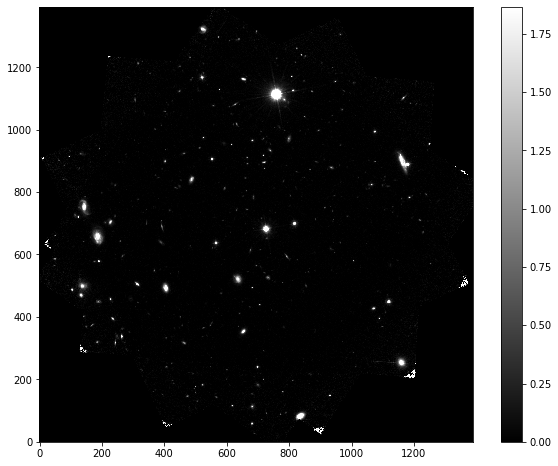

In [10]:
from scipy import ndimage
data = fitsio.read('/content/final_test_phot_drz.fits')
data = np.nan_to_num(data, copy=True, nan=0)
data = ndimage.rotate(data, -ori, reshape=False)

m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=0, vmax=m*s, origin='lower')
plt.colorbar();
print(m,s)

In [11]:
#understand order='C'
data = data.copy(order='C')
bkg = sep.Background(data)

In [12]:
bkg = sep.Background(data, bw=64, bh=64, fw=3, fh=3)

In [13]:
print(bkg.globalback)
print(bkg.globalrms)

-0.000944922212511301
0.02069132588803768


In [14]:
bkg_image = np.array(bkg)

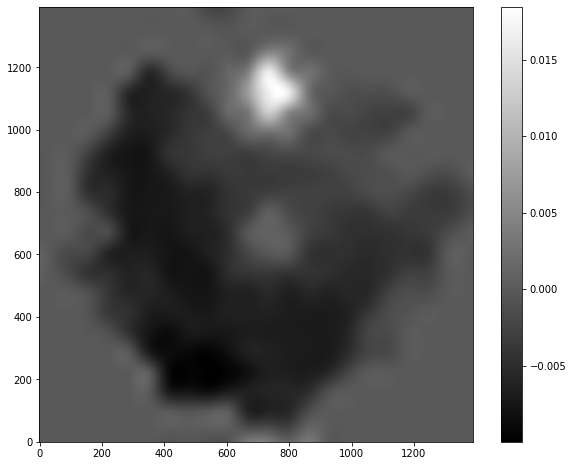

In [15]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [16]:
bkg_rms = bkg.rms()

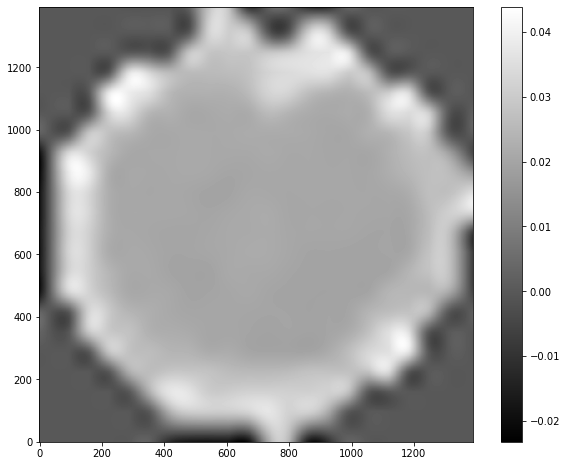

In [17]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [18]:
data_sub = data - bkg

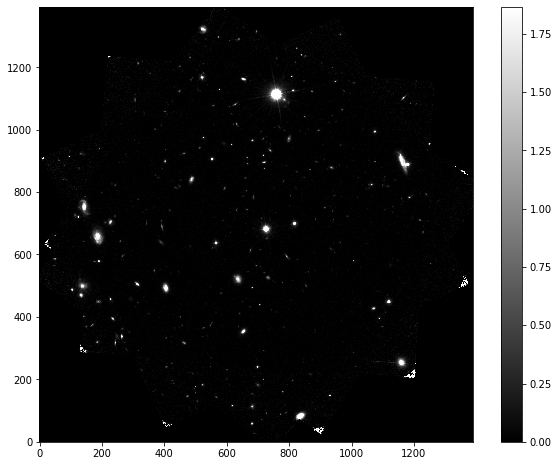

In [19]:
plt.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=0, vmax=m*s, origin='lower')
plt.colorbar();

In [368]:
m, s = np.mean(data_sub), np.std(data_sub)
#understand why threshold of 2 works given that image max ~2
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
len(objects)

2495

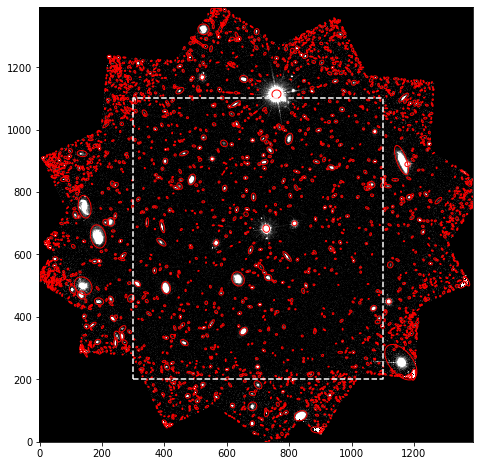

In [374]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=0, vmax=0.5, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.plot([300,1100,1100,300,300],[200,200,1100,1100,200],color='white',linestyle='--')

# plt.scatter(final['x'].values,final['y'].values)

In [375]:
loc =  np.where((objects['x'] < 1100) & (objects['x'] > 300) & (objects['y'] < 1100) & (objects['y'] > 200))
objects = objects[loc]

In [391]:
len(objects)

761

In [376]:
kronrad, krflag = sep.kron_radius(data, objects['x'], objects['y'], objects['a'], objects['b'], objects['theta'], r=4.0)
flux, fluxerr, flag = sep.sum_ellipse(data, x=objects['x'], y=objects['y'], a=objects['a'], b=objects['b'], theta=objects['theta'], err=bkg.globalrms, r=2.75*kronrad, subpix=1)
flag |= krflag  # combine flags into 'flag'

r_min = 0.  # minimum diameter = 3.5
use_circle = kronrad * np.sqrt(objects['a'] * objects['b']) < r_min
cflux, cfluxerr, cflag = sep.sum_circle(data, objects['x'][use_circle], objects['y'][use_circle],
                                        r_min, subpix=1, err=bkg.globalrms)
flux[use_circle] = cflux
fluxerr[use_circle] = cfluxerr
flag[use_circle] = cflag

In [377]:
final = pd.DataFrame(objects)

In [378]:
final['flux'] = flux
final['fluxerr'] = fluxerr

In [379]:
for i,row in final.iterrows():
    ra,dec = convert_pixel_ra_dec(row[['x','y']].values,crval1,crval2)
    mag = flux_to_mag(row['flux'],10.6)
    final.at[i,'ra'] = ra
    final.at[i,'dec'] = dec
    final.at[i,'mag'] = mag

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [380]:
df = pd.read_csv('/content/table4_ext.dat',sep="\s+",names=['Name','RAd','DEd','mF140W','e_mF140W','Redshift','b','Mstar','m_Mstar','p_Mstar','Mhalo','m_Mhalo','p_Mhalo','Rvir','m_Rvir','p_Rvir','SFR','m_SFR','p_SFR'])

In [381]:
df = df.rename(columns={'RAd':'ra','DEd':'dec'})

In [382]:
for i,row in final.iterrows():
    ra,dec = convert_pixel_ra_dec(row[['x','y']].values,crval1,crval2)
    mag = flux_to_mag(row['flux'],0)
    final.at[i,'ra'] = ra
    final.at[i,'dec'] = dec
    final.at[i,'mag'] = mag

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [383]:
d,u = cross_ref(final,df,tol=1/3600)

mdf shape: (761, 34)



discovered: 30
undiscovered: 2


(19.0, 27.0)

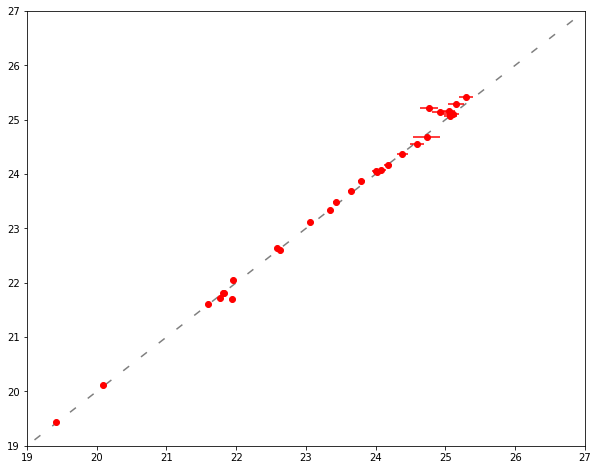

In [384]:
plt.scatter(d['mF140W'].values,d['mag'].values+26.450,zorder=100,color='red',s=10)
plt.plot([0,100],[0,100],color='black',linestyle=(0,(5,10)),alpha=0.5)
plt.errorbar(d['mF140W'].values,d['mag'].values,xerr=d['e_mF140W'].values,color='red', fmt='o')
plt.xlim(19,27)
plt.ylim(19,27)
#show residual

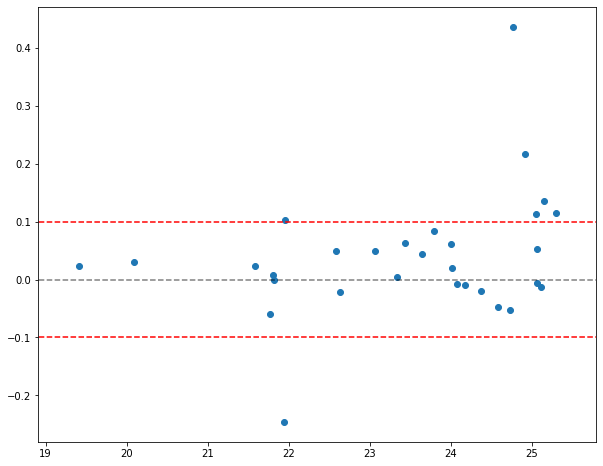

In [385]:
res = d['mag'].values-d['mF140W'].values
plt.scatter(d['mF140W'].values,res)
plt.xlim([d['mF140W'].values.min()-0.5,d['mF140W'].values.max()+0.5])
plt.plot([d['mF140W'].values.min()-1,d['mF140W'].values.max()+1],[0.1,0.1],color='red',linestyle='--')
plt.plot([d['mF140W'].values.min()-1,d['mF140W'].values.max()+1],[-0.1,-0.1],color='red',linestyle='--')
plt.plot([d['mF140W'].values.min()-1,d['mF140W'].values.max()+1],[0,0],color='black',alpha=0.5,linestyle='--')
#residual should be my value - truth  

In [386]:
def rms(array):
   return np.sqrt(np.mean(array ** 2))

In [387]:
d['res'] = d['mag'] - d['mF140W']

In [389]:
print(rms(d['res']))
print(rms(d[d['mag']<25]['res']))

0.11414151684989686
0.06908352100834156


truth: 21.94 CS: 21.69


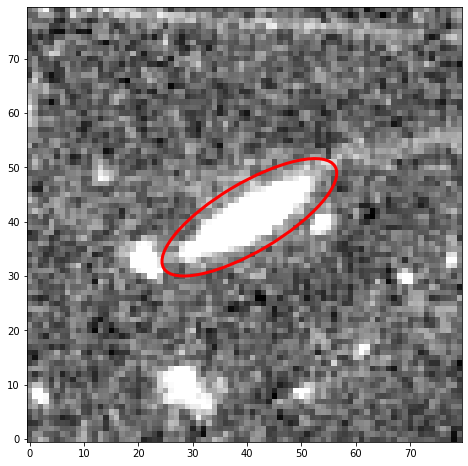

truth: 24.92 CS: 25.14


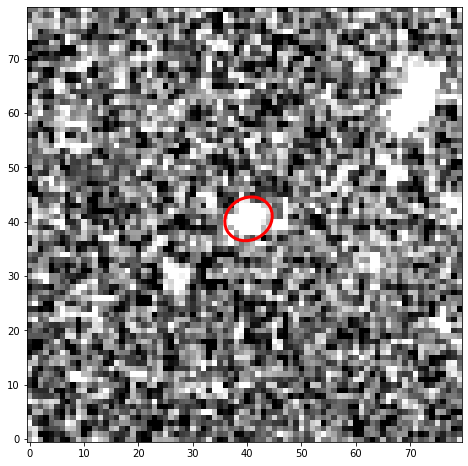

truth: 24.77 CS: 25.21


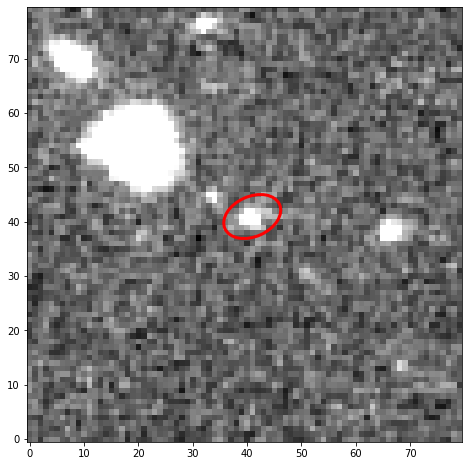

In [392]:
final = pd.DataFrame(columns=['x','y','flux','err'])
for i,row in d.sort_values(by='res').iterrows():
    if abs(row['res'])>0.2:
        print('truth:',row['mF140W'],'CS:',np.round(row['mag'],2))
        x,y = row['x'], row['y']
        # print("object {:d}: flux = {:f} +/- {:f}, x = {:f}, y = {:f}".format(i,f,err,x,y))
        fig, ax = plt.subplots()
        data_new = data_sub[int(y)-40:int(y)+40,int(x)-40:int(x)+40]
        m, s = np.mean(data_new), np.std(data_new)
        im = ax.imshow(data_new, interpolation='nearest', cmap='gray',
                    vmin=m-s, vmax=m+s, origin='lower')
        e = Ellipse(xy=(40+(x-int(x)), 40+(y-int(y))),
                    width=6*row['a'],
                    height=6*row['b'],
                    angle=row['theta'] * 180. / np.pi,linewidth=3)
        e.set_facecolor('none')
        e.set_edgecolor('red')
        ax.add_artist(e)
        plt.show()

In [358]:
d['res']

351    0.023278
600    0.084297
605    0.049568
413   -0.022066
486   -0.051818
681   -0.000663
578    0.043431
383    0.114034
483    0.040449
883   -0.246115
550    0.217402
670    0.049991
641   -0.013626
431    0.103239
405    0.007584
507    0.005021
462   -0.059309
348    0.063666
552   -0.007523
514    0.136530
534    0.020377
595    0.029768
335    0.436810
343    0.022856
434    0.052530
274    0.114751
470   -0.005403
476    0.062193
692   -0.009597
653   -0.046745
418   -0.020568
Name: res, dtype: float64